In [0]:
import nltk
import pandas as pd

In [5]:
# Import preprocessed quora and ask ubuntu datasets
quora_df = pd.read_csv('preprocessed_Quora.csv', sep='\t', )
print(quora_df.shape)
quora_df.head()

(404287, 3)


,is_duplicate,question1,question2
0,0,step by step guide invest in share market in i...,step by step guide invest in share market
1,0,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,0,how can i increase speed my internet connectio...,how can internet speed be increased by hacking...
3,0,why am i mentally very lonely how can i solve it,find remainder when math2324math divided by 2423
4,0,one dissolve in water quikly sugar salt methan...,fish would survive in salt water


In [6]:
askubuntu_df = pd.read_csv('preprocessed_AskUbuntu.csv', sep='\t')
print(askubuntu_df.shape)
askubuntu_df.head()

(36947, 3)


,is_duplicate,question1,question2
0,1,why does badsiggpg error keep appearing again ...,how fix gpg errorbadsig running aptget update
1,1,how remove wubi installed ubuntu without affec...,how do i uninstall ubuntu wubi
2,1,english dictionary in libreoffice,how install libreoffice language tools spellin...
3,1,start problem with radeon,unable boot 1110 due graphic driver problem wi...
4,1,how view ubuntu files from windows,how read ext4 partitions in windows


In [33]:
final_df = pd.concat([quora_df, askubuntu_df], ignore_index=True)
print(final_df.shape)
print(type(final_df))
final_df.head()

(441234, 3)
<class 'pandas.core.frame.DataFrame'>


,is_duplicate,question1,question2
0,0,step by step guide invest in share market in i...,step by step guide invest in share market
1,0,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...
2,0,how can i increase speed my internet connectio...,how can internet speed be increased by hacking...
3,0,why am i mentally very lonely how can i solve it,find remainder when math2324math divided by 2423
4,0,one dissolve in water quikly sugar salt methan...,fish would survive in salt water


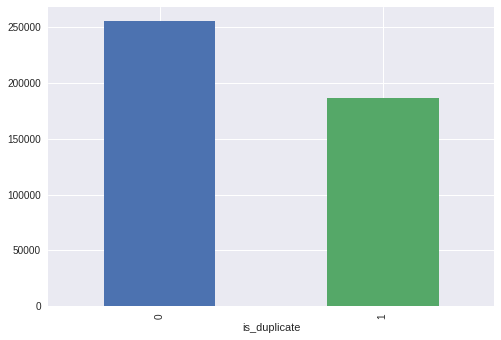

In [8]:
final_df.groupby("is_duplicate").size().plot.bar()

In [34]:
# Divide final dataframe into test and train datasets
df = final_df.sample(frac=1)
print(type(df))
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
(441234, 3)


,is_duplicate,question1,question2
370822,0,are some good documentaries jesus bible,are best documentaries jesuss life
166738,0,do you think new design on quora july 2013,do you like quoras new design
50925,1,are balaji vishwanathans views on astrology,does balaji viswanathan feel astrology
193124,0,are some tips on making it job interview proce...,are some tips on making it job interview proce...
245517,0,does masturbation affects our health fertility,how harmful unhealthy masturbation


## **BOW + Xgboost Model**

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import scipy
import xgboost as xgb

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
concatQues = pd.concat((df['question1'],df['question2'])).unique()
concatQues = pd.Series(concatQues)
count_vect.fit(concatQues.values.astype('U'))
trainq1_trans = count_vect.transform(df['question1'].values.astype('U'))
trainq2_trans = count_vect.transform(df['question2'].values.astype('U'))
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
Y = labels
X_train,X_valid,Y_train,Y_valid = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape)
print(X_valid.shape)
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)
print(xgb_prediction)

(295626, 232024)
(145608, 232024)
[1 1 1 ... 0 0 0]


In [57]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

training score: 0.8024832069232679
validation score: 0.7624650825629291
              precision    recall  f1-score   support

           0       0.76      0.90      0.82     84146
           1       0.82      0.61      0.70     61462

   micro avg       0.78      0.78      0.78    145608
   macro avg       0.79      0.76      0.76    145608
weighted avg       0.79      0.78      0.77    145608



In [0]:
import pickle
filename = 'bow_xgboost_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))
 
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

## Word level Tf-idf

In [0]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
concatQues = pd.concat((df['question1'],df['question2'])).unique()
concatQues = pd.Series(concatQues)
tfidf_vect.fit(concatQues.values.astype('U'))
trainq1_trans = tfidf_vect.transform(df['question1'].values.astype('U'))
trainq2_trans = tfidf_vect.transform(df['question2'].values.astype('U'))
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [60]:
from sklearn.metrics import f1_score, classification_report, accuracy_score
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
filename = 'word_tfidf_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))
xgb_prediction = xgb_model.predict(X_valid)
print('word level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('word level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

word level tf-idf training score: 0.8372299798607095
word level tf-idf validation score: 0.7671235861855303
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     84146
           1       0.82      0.62      0.71     61462

   micro avg       0.78      0.78      0.78    145608
   macro avg       0.79      0.76      0.77    145608
weighted avg       0.79      0.78      0.78    145608



## N-gram Level TF-IDF

In [0]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
concatQues = pd.concat((df['question1'],df['question2'])).unique()
concatQues = pd.Series(concatQues)
tfidf_vect_ngram.fit(concatQues.values.astype('U'))
train_q1 = tfidf_vect_ngram.transform(df['question1'].values.astype('U'))
train_q2 = tfidf_vect_ngram.transform(df['question2'].values.astype('U'))
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((train_q1,train_q2))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [62]:
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
filename = 'ngram_tfidf_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))
xgb_prediction = xgb_model.predict(X_valid)
print('n-gram level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('n-gram level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

n-gram level tf-idf training score: 0.6939196766079507
n-gram level tf-idf validation score: 0.6655056493823306
              precision    recall  f1-score   support

           0       0.68      0.93      0.79     84146
           1       0.81      0.41      0.54     61462

   micro avg       0.71      0.71      0.71    145608
   macro avg       0.74      0.67      0.67    145608
weighted avg       0.73      0.71      0.68    145608



## Character Level TF-IDF

In [64]:
from sklearn.metrics import f1_score, classification_report, accuracy_score
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
concatQues = pd.concat((df['question1'],df['question2'])).unique()
concatQues = pd.Series(concatQues)
tfidf_vect_ngram_chars.fit(concatQues.values.astype('U'))
train_q1 = tfidf_vect_ngram_chars.transform(df['question1'].values.astype('U'))
train_q2 = tfidf_vect_ngram_chars.transform(df['question2'].values.astype('U'))
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((train_q1,train_q2))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
filename = 'char_tfidf_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))
xgb_prediction = xgb_model.predict(X_valid)
print('character level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('character level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

character level tf-idf training score: 0.9928387652283919
character level tf-idf validation score: 0.8168140099820946
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     84146
           1       0.84      0.72      0.78     61462

   micro avg       0.83      0.83      0.83    145608
   macro avg       0.83      0.81      0.82    145608
weighted avg       0.83      0.83      0.82    145608

